In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch

In [4]:
device = torch.device("mps")
device

device(type='mps')

$$
\frac{\partial^2 T(x,y,t)}{\partial x^2} + \frac{\partial^2 T(x,y,t)}{\partial y^2} -\frac{1}{\alpha}\frac{\partial T(x,y,t)}{\partial t} = 0
$$

$T(x,y,z)$ is neural network.

In [92]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_in = torch.nn.Linear(3, 10) # x, y, t
        for i in range(12):
            setattr(self, f'fc{i}', torch.nn.Linear(10, 10))
        self.fc_out = torch.nn.Linear(10, 1) # T
        self.act = torch.nn.SiLU() # for continuity
        self.norm = torch.nn.BatchNorm1d(10)
    
    def forward(self, x:torch.Tensor, y:torch.Tensor, t:torch.Tensor) -> torch.Tensor:
        x = torch.cat((x, y, t), dim=1)
        x = self.act(self.fc_in(x))
        for i in range(12):
            x = getattr(self, f'fc{i}')(x)
            x = self.norm(x)
            x = self.act(x)
        x = self.fc_out(x)
        return x
    
def func(net:torch.nn.Module, x:torch.Tensor, y:torch.Tensor, t:torch.Tensor) -> torch.Tensor:
    T = net(x, y, t)
    T_x = torch.autograd.grad(T, x, torch.ones_like(T), create_graph=True)[0]
    T_xx = torch.autograd.grad(T_x, x, torch.ones_like(T_x), create_graph=True)[0]
    T_y = torch.autograd.grad(T, y, torch.ones_like(T), create_graph=True)[0]
    T_yy = torch.autograd.grad(T_y, y, torch.ones_like(T_y), create_graph=True)[0]
    T_t = torch.autograd.grad(T, t, torch.ones_like(T), create_graph=True)[0]
    return T_t - T_xx - T_yy

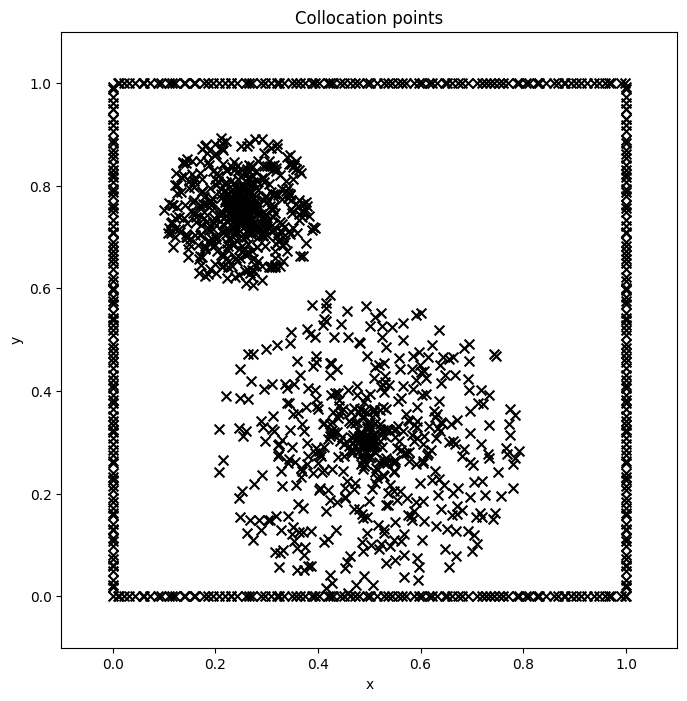

In [90]:
# init condition

# boundary box
init_cond_coord_0 = sp.stats.qmc.LatinHypercube(d=2).random(n=100)
init_cond_coord_0 = sp.stats.qmc.scale(init_cond_coord_0, [0, 0], [1, 1])
init_cond_x_0, init_cond_y_0 = init_cond_coord_0[:, 0], init_cond_coord_0[:, 1]
init_cond_i_0 = np.zeros_like(init_cond_x_0)
init_cond_o_0 = np.full_like(init_cond_x_0, 1)
init_cond_t_0 = np.full_like(init_cond_x_0, 0)
init_cond_u_0 = np.full_like(init_cond_x_0, 1)

# circle 0
radius_0 = 0.15
center_0 = np.array([0.25, 0.75])
init_cond_coord_1 = sp.stats.qmc.LatinHypercube(d=2).random(n=500)
init_cond_coord_1 = sp.stats.qmc.scale(init_cond_coord_1, [0, 0], [2 * np.pi, radius_0])
init_cond_theta_1, init_cond_r_1 = init_cond_coord_1[:, 0], init_cond_coord_1[:, 1]
init_cond_x_1 = center_0[0] + init_cond_r_1 * np.cos(init_cond_theta_1)
init_cond_y_1 = center_0[1] + init_cond_r_1 * np.sin(init_cond_theta_1)
init_cond_t_1 = np.full_like(init_cond_x_1, 0)
init_cond_u_1 = np.full_like(init_cond_x_1, 0)

# circle 1
radius_1 = 0.3
center_1 = np.array([0.5, 0.3])
init_cond_coord_2 = sp.stats.qmc.LatinHypercube(d=2).random(n=500)
init_cond_coord_2 = sp.stats.qmc.scale(init_cond_coord_2, [0, 0], [2 * np.pi, radius_1])
init_cond_theta_2, init_cond_r_2 = init_cond_coord_2[:, 0], init_cond_coord_2[:, 1]
init_cond_x_2 = center_1[0] + init_cond_r_2 * np.cos(init_cond_theta_2)
init_cond_y_2 = center_1[1] + init_cond_r_2 * np.sin(init_cond_theta_2)
init_cond_t_2 = np.full_like(init_cond_x_2, 0)
init_cond_u_2 = np.full_like(init_cond_x_2, 0)

plt.figure(figsize=(8, 8))
plt.scatter(init_cond_x_0, init_cond_i_0, s=50, marker='x', c='k')
plt.scatter(init_cond_x_0, init_cond_o_0, s=50, marker='x', c='k')
plt.scatter(init_cond_i_0, init_cond_y_0, s=50, marker='x', c='k')
plt.scatter(init_cond_o_0, init_cond_y_0, s=50, marker='x', c='k')

plt.scatter(init_cond_x_1, init_cond_y_1, s=50, marker='x', c='k')
plt.scatter(init_cond_x_2, init_cond_y_2, s=50, marker='x', c='k')

plt.title('Collocation points')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [114]:
net = Net().to(device)
criterion = torch.nn.MSELoss()

history = []
best_loss = float('inf')
best_net = None
steps = 0

In [115]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [116]:
def get_init_cond(n_samples:int=500, device=None):
    init_cond_coord_0 = torch.rand(
        (n_samples, 2, 1), device=device, requires_grad=False, dtype=torch.float32)
    init_cond_x_0 = init_cond_coord_0[:, 0, :]
    init_cond_y_0 = init_cond_coord_0[:, 1, :]
    init_cond_i_0 = torch.zeros(
        (n_samples, 1), device=device, requires_grad=False, dtype=torch.float32)
    init_cond_o_0 = torch.ones(
        (n_samples, 1), device=device, requires_grad=False, dtype=torch.float32)
    init_cond_t_0 = torch.zeros(
        (n_samples, 1), device=device, requires_grad=False, dtype=torch.float32)
    init_cond_u_0 = torch.ones(
        (n_samples, 1), device=device, requires_grad=False, dtype=torch.float32)
    
    init_cond_x = torch.cat([
        init_cond_x_0, init_cond_x_0, init_cond_i_0, init_cond_o_0], dim=0)
    init_cond_y = torch.cat([
        init_cond_i_0, init_cond_o_0, init_cond_y_0, init_cond_y_0], dim=0)
    init_cond_t = torch.cat([
        init_cond_t_0, init_cond_t_0, init_cond_t_0, init_cond_t_0], dim=0)
    init_cond_u = torch.cat([
        init_cond_u_0, init_cond_u_0, init_cond_u_0, init_cond_u_0], dim=0)
    
    radius_1 = 0.15
    center_1 = torch.tensor(
        [0.25, 0.75], device=device, requires_grad=False, dtype=torch.float32)
    init_cond_coord_1 = torch.rand(
        (n_samples, 2, 1), device=device, requires_grad=False, dtype=torch.float32)
    init_cond_theta_1 = init_cond_coord_1[:, 0, :] * 2 * np.pi
    init_cond_r_1 = init_cond_coord_1[:, 1, :] * radius_1
    init_cond_x_1 = center_1[0] + init_cond_r_1 * torch.cos(init_cond_theta_1)
    init_cond_y_1 = center_1[1] + init_cond_r_1 * torch.sin(init_cond_theta_1)
    init_cond_t_1 = torch.zeros(
        (n_samples, 1), device=device, requires_grad=False, dtype=torch.float32)
    init_cond_u_1 = torch.zeros(
        (n_samples, 1), device=device, requires_grad=False, dtype=torch.float32)
    
    radius_2 = 0.1
    center_2 = torch.tensor(
        [0.5, 0.25], device=device, requires_grad=False, dtype=torch.float32)
    init_cond_coord_2 = torch.rand(
        (n_samples, 2, 1), device=device, requires_grad=False, dtype=torch.float32)
    init_cond_theta_2 = init_cond_coord_2[:, 0, :] * 2 * np.pi
    init_cond_r_2 = init_cond_coord_2[:, 1, :] * radius_2
    init_cond_x_2 = center_2[0] + init_cond_r_2 * torch.cos(init_cond_theta_2)
    init_cond_y_2 = center_2[1] + init_cond_r_2 * torch.sin(init_cond_theta_2)
    init_cond_t_2 = torch.zeros(
        (n_samples, 1), device=device, requires_grad=False, dtype=torch.float32)
    init_cond_u_2 = torch.zeros(
        (n_samples, 1), device=device, requires_grad=False, dtype=torch.float32)
    
    init_cond_x = torch.cat([
        init_cond_x, init_cond_x_1, init_cond_x_2], dim=0)
    init_cond_y = torch.cat([
        init_cond_y, init_cond_y_1, init_cond_y_2], dim=0)
    init_cond_t = torch.cat([
        init_cond_t, init_cond_t_1, init_cond_t_2], dim=0)
    init_cond_u = torch.cat([
        init_cond_u, init_cond_u_1, init_cond_u_2], dim=0)
    return init_cond_x, init_cond_y, init_cond_t, init_cond_u

In [117]:
def get_bnd_cond(n_samples:int=500, device=None):
    bnd_cond_coord_0 = torch.rand(
        (n_samples, 3, 1), device=device, requires_grad=False, dtype=torch.float32)
    bnd_cond_x_0 = bnd_cond_coord_0[:, 0, :]
    bnd_cond_y_0 = bnd_cond_coord_0[:, 1, :]
    bnd_cond_t_0 = bnd_cond_coord_0[:, 2, :]
    bnd_cond_i_0 = torch.zeros(
        (n_samples, 1), device=device, requires_grad=False, dtype=torch.float32)
    bnd_cond_o_0 = torch.ones(
        (n_samples, 1), device=device, requires_grad=False, dtype=torch.float32)
    bnd_cond_u_0 = torch.zeros(
        (n_samples, 1), device=device, requires_grad=False, dtype=torch.float32)
    
    bnd_cond_x = torch.cat([
        bnd_cond_x_0, bnd_cond_x_0, bnd_cond_i_0, bnd_cond_o_0], dim=0)
    bnd_cond_y = torch.cat([
        bnd_cond_i_0, bnd_cond_o_0, bnd_cond_y_0, bnd_cond_y_0], dim=0)
    bnd_cond_t = torch.cat([
        bnd_cond_t_0, bnd_cond_t_0, bnd_cond_t_0, bnd_cond_t_0], dim=0)
    bnd_cond_u = torch.cat([
        bnd_cond_u_0, bnd_cond_u_0, bnd_cond_u_0, bnd_cond_u_0], dim=0)
    
    radius_1 = 0.15
    center_1 = torch.tensor(
        [0.25, 0.75], device=device, requires_grad=False, dtype=torch.float32)
    bnd_cond_coord_1 = torch.rand(
        (n_samples, 3, 1), device=device, requires_grad=False, dtype=torch.float32)
    bnd_cond_theta_1 = bnd_cond_coord_1[:, 0, :] * 2 * torch.pi
    bnd_cond_r_1 = bnd_cond_coord_1[:, 1, :] * radius_1
    bnd_cond_t_1 = bnd_cond_coord_1[:, 2, :]
    bnd_cond_x_1 = center_1[0] + bnd_cond_r_1 * torch.cos(bnd_cond_theta_1)
    bnd_cond_y_1 = center_1[1] + bnd_cond_r_1 * torch.sin(bnd_cond_theta_1)
    bnd_cond_u_1 = torch.ones(
        (n_samples, 1), device=device, requires_grad=False, dtype=torch.float32)

    radius_2 = 0.1
    center_2 = torch.tensor(
        [0.5, 0.3], device=device, requires_grad=False, dtype=torch.float32)
    bnd_cond_coord_2 = torch.rand(
        (n_samples, 3, 1), device=device, requires_grad=False, dtype=torch.float32)
    bnd_cond_theta_2 = bnd_cond_coord_2[:, 0, :] * 2 * torch.pi
    bnd_cond_r_2 = bnd_cond_coord_2[:, 1, :] * radius_2
    bnd_cond_t_2 = bnd_cond_coord_2[:, 2, :]
    bnd_cond_x_2 = center_2[0] + bnd_cond_r_2 * torch.cos(bnd_cond_theta_2)
    bnd_cond_y_2 = center_2[1] + bnd_cond_r_2 * torch.sin(bnd_cond_theta_2)
    bnd_cond_u_2 = torch.ones(
        (n_samples, 1), device=device, requires_grad=False, dtype=torch.float32)

    bnd_cond_x = torch.cat([bnd_cond_x, bnd_cond_x_1, bnd_cond_x_2], dim=0)
    bnd_cond_y = torch.cat([bnd_cond_y, bnd_cond_y_1, bnd_cond_y_2], dim=0)
    bnd_cond_t = torch.cat([bnd_cond_t, bnd_cond_t_1, bnd_cond_t_2], dim=0)
    bnd_cond_u = torch.cat([bnd_cond_u, bnd_cond_u_1, bnd_cond_u_2], dim=0)
    
    return bnd_cond_x, bnd_cond_y, bnd_cond_t, bnd_cond_u

In [118]:
def get_colloc_cond(n_samples:int=3000, device=None):
    colloc_coord = torch.rand(
        (n_samples, 3, 1), device=device, requires_grad=True, dtype=torch.float32)
    colloc_x = colloc_coord[:, 0, :]
    colloc_y = colloc_coord[:, 1, :]
    colloc_t = colloc_coord[:, 2, :]
    colloc_u = torch.zeros(
        (n_samples, 1), device=device, requires_grad=False, dtype=torch.float32)
    return colloc_x, colloc_y, colloc_t, colloc_u

In [119]:
EPOCHS = 10000

for epoch in range(EPOCHS):
    loss_tmp = []
    init_x, init_y, init_t, init_u = get_init_cond(n_samples=500, device=device)
    bnd_x, bnd_y, bnd_t, bnd_u = get_bnd_cond(n_samples=500, device=device)
    colloc_x, colloc_y, colloc_t, colloc_u = get_colloc_cond(n_samples=500, device=device)
    
    optimizer.zero_grad()
    init_pred = net(init_x, init_y, init_t)
    bnd_pred = net(bnd_x, bnd_y, bnd_t)
    colloc_pred = func(net, colloc_x, colloc_y, colloc_t)
    loss = criterion(init_pred, init_u) + criterion(bnd_pred, bnd_u) + criterion(colloc_pred, colloc_u)
    loss.backward()
    loss_tmp.append(loss.item())
    optimizer.step()
    
    if np.mean(loss_tmp) < best_loss:
        best_loss = np.mean(loss_tmp)
        best_net = net
    
    steps += 1

    print(f'\rEpoch [{epoch+1}/{EPOCHS}], Steps [{steps}] Loss: {np.mean(loss_tmp):.5f}', end='')
    history.append(np.mean(loss_tmp))

Epoch [7476/10000], Steps [7476] Loss: 0.21940

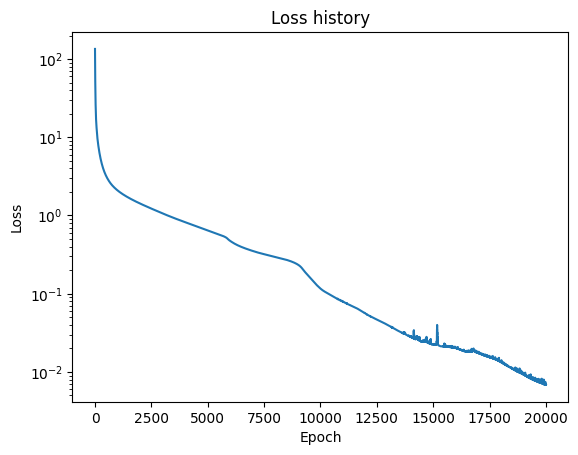

In [106]:
plt.plot(history)
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [105]:
T = np.linspace(0, 1, 300)

for i, ti in enumerate(T):
    print(f'Plotting {i+1}/{len(T)}', end='\r')
    fig = plt.figure(figsize=(10, 10))

    x = np.arange(0, 1, 0.001)
    y = np.arange(0, 1, 0.001)

    ms_x, ms_y = np.meshgrid(x, y)
    ms_t = np.full_like(ms_x, ti)

    x = np.ravel(ms_x).reshape(-1, 1)
    y = np.ravel(ms_y).reshape(-1, 1)
    t = np.ravel(ms_t).reshape(-1, 1)

    pt_x = torch.autograd.Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
    pt_y = torch.autograd.Variable(torch.from_numpy(y).float(), requires_grad=True).to(device)
    pt_t = torch.autograd.Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)

    with torch.no_grad():
        pt_u = best_net.to(device)(pt_x, pt_y, pt_t)
    u = pt_u.data.cpu().numpy()
    ms_u = u.reshape(ms_x.shape)

    plt.imshow(ms_u, vmin=0, extent=[0, 1, 0, 1], cmap='jet')
    plt.colorbar()
    plt.savefig(f'figs/{i:04d}.png', bbox_inches='tight')
    plt.close()